In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.utils import shuffle as sklearnShuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from numpy.random import shuffle
from keras.models import Model
from random import randint
from keras.models import load_model

# Visualizations will be shown in the notebook.
%matplotlib inline


Using TensorFlow backend.


In [2]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                if 'flipped' in name and 'translated' in name:
                    rand = name.split('_')[0]
                    name = name.replace(rand +'_translated_flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                    image = translation(image, float(rand))
                elif 'flipped' in name:
                    name = name.replace('flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                elif 'translated' in name:
                    rand = name.split('_')[0]
                    name = name.replace(rand +'_translated_', '')
                    image = imread("./data/IMG/" + name)
                    image = translation(image, float(rand))
                else:
                    image = imread("./data/IMG/" + name)
                #image = cv2.resize(image, (80,160))
                angle = float(batch_sample[1])
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearnShuffle(X_train, y_train)

In [3]:
def generator_predict(samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
               
                if 'flipped' in name and 'translated' in name:
                    rand = name.split('_')[0]
                    name = name.replace(rand +'_translated_flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                    image = translation(image, float(rand))
                elif 'flipped' in name:
                    name = name.replace('flipped_', '')
                    image = imread("./data/IMG/" + name)
                    image = np.fliplr(image)
                elif 'translated' in name:
                    rand = name.split('_')[0]
                    name = name.replace(rand +'_translated_', '')
                    image = imread("./data/IMG/" + name)
                    image = translation(image, float(rand))
                else:
                    image = imread("./data/IMG/" + name)
                
                #image = cv2.resize(image, (80,160))
                images.append(image)
                
            images = np.array(images)
            yield images
            

In [4]:
def samples_view(samples):
    bins = [(i - 0.5)/100 for i in range(-100, 102)]
    plt.figure(figsize=(5, 5))
    plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
    plt.title('Samples distribution')
    plt.xlabel('steering angle')
    plt.show()
    print('shape of sample set: {}'.format(samples.shape))
    print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))

In [5]:
def split_samples(samples, test_size=0.1):
    bins = [(i - 0.5)/100 for i in range(-100, 102)]
    train_samples, validation_samples = train_test_split(samples, test_size=test_size, random_state=0)
    fig, (train, validation) = plt.subplots(ncols=2, figsize=(10, 4))
    train.hist(train_samples[:,1].astype(float), bins, color = 'b')
    train.set_title('train labels')
    validation.hist(validation_samples[:,1].astype(float), bins, color = 'g')
    validation.set_title('validation labels')
    plt.show()
    print('shape of train sample set: {}'.format(train_samples.shape))
    print('shape of validation sample set: {}'.format(validation_samples.shape))
    print('Train labeling - mean: {}, std: {}, min: {}, max: {}'.format(train_samples[:,1].astype(float).mean(),
                                                                      train_samples[:,1].astype(float).std(),
                                                                      train_samples[:,1].astype(float).min(),
                                                                      train_samples[:,1].astype(float).max()))
    print('Validation labeling - mean: {}, std: {}, min: {}, max: {}'.format(validation_samples[:,1].astype(float).mean(),
                                                                      validation_samples[:,1].astype(float).std(),
                                                                      validation_samples[:,1].astype(float).min(),
                                                                      validation_samples[:,1].astype(float).max()))
    
    return train_samples, validation_samples

In [6]:
### plot the training and validation loss for each epoch
def training_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [7]:
def evaluate(validation_samples):
    validation_generator = generator(validation_samples, batch_size=32)
    val_loss = model.evaluate_generator(generator=validation_generator, val_samples=len(validation_samples))
    print('Validation Loss: {}'.format(val_loss))
        
    val_pred = model.predict_generator(generator_predict(validation_samples), val_samples=len(validation_samples))

    bins = [(i - 0.5)/100 for i in range(-100, 102)]
    fig, (predict, truth) = plt.subplots(ncols=2, figsize=(10, 4))
    predict.hist(val_pred, bins, color = 'b')
    predict.set_title('Predict labels')
    truth.hist(validation_samples[:,1].astype(float), bins, color = 'g')
    truth.set_title('True labels')
    plt.show()

    print('Prediction - mean: {}, std: {}, min: {}, max: {}'.format(val_pred.mean(),val_pred.std(),
                                                             val_pred.min(),val_pred.max()))
    print('Initial labeling - mean: {}, std: {}, min: {}, max: {}'.format(validation_samples[:,1].astype(float).mean()
                                                                      ,validation_samples[:,1].astype(float).std(),
                                                                      validation_samples[:,1].astype(float).min(),
                                                                      validation_samples[:,1].astype(float).max()))

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']


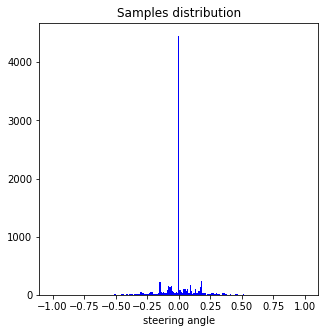

shape of sample set: (8036, 2)
Samples labeling - mean: 0.0040696440648332515, std: 0.12883205581793244, min: -0.9426954, max: 1.0


In [8]:
samples = []

with open('./data/driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[3] == 'steering': 
                print(row)
            else:
                img_center = row[0].split("\\")[-1]
                img_center = img_center.split("/")[-1]
                steering_center = float(row[3])
                samples.append([img_center, steering_center])

samples = np.array(samples)

samples_view(samples)

center_2016_12_01_13_30_48_287.jpg
Shape of image: (160, 320, 3)


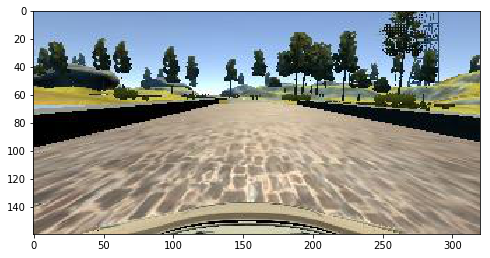

In [9]:
ex_name = samples[0,0]
print(ex_name)
ex_image = imread("./data/IMG/" + ex_name)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))

"""ex_image = cv2.resize(ex_image, (80,160))
plt.figure(figsize=(4,4))
plt.imshow(ex_image)
print('Shape of resized image: {}'.format(ex_image.shape))"""

input_shape = ex_image.shape # Image shape



Shape of image: (80, 320, 3)


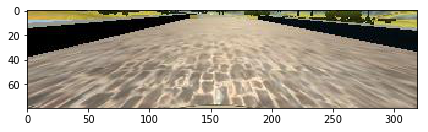

In [10]:
crop_img = ex_image[60:-20, :]
plt.figure(figsize=(7,6))
plt.imshow(crop_img)
print('Shape of image: {}'.format(crop_img.shape))

In [40]:
model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=input_shape))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(5,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(10,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(20,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(30,3,3, activation="relu"))
model.add(Convolution2D(30,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_3 (Cropping2D)        (None, 80, 320, 3)    0           cropping2d_input_6[0][0]         
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 80, 320, 3)    0           cropping2d_3[0][0]               
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 76, 316, 5)    380         lambda_3[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 38, 158, 5)    0           convolution2d_11[0][0]           
___________________________________________________________________________________________

Shape of image: (160, 320, 3)
dtype of image: uint8


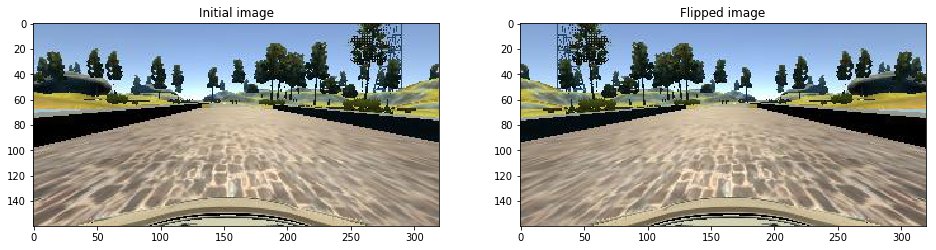

In [12]:
ex_image = imread("./data/IMG/" + ex_name)
flipped_image = np.fliplr(ex_image)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Initial image')
plt.imshow(ex_image)
plt.subplot(122)
plt.title('Flipped image')
plt.imshow(flipped_image)
print('Shape of image: {}'.format(flipped_image.shape))
print('dtype of image: {}'.format(flipped_image.dtype))

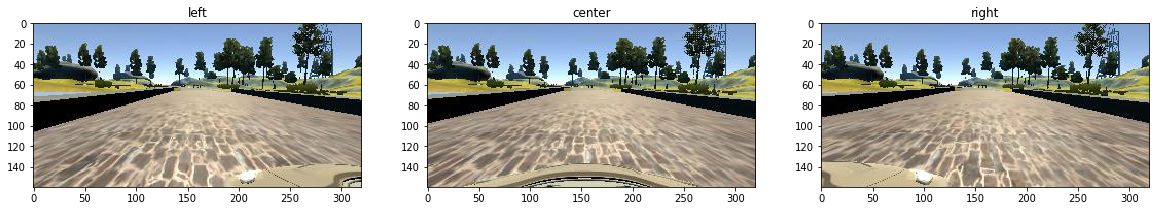

In [13]:
plt.figure(figsize=(20,8))
plt.subplot(131)
plt.title('left')
plt.imshow(imread('./data/IMG/' + ex_name.replace('center', 'left')))
plt.subplot(132)
plt.title('center')
plt.imshow(imread('./data/IMG/' + ex_name))
plt.subplot(133)
plt.title('right')
plt.imshow(imread('./data/IMG/' + ex_name.replace('center', 'right')))

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']


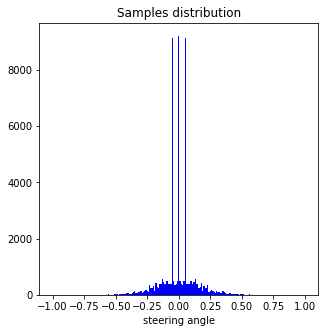

shape of sample set: (48216, 2)
Samples labeling - mean: 8.577195882546682e-20, std: 0.13517552986541395, min: -1.0, max: 1.0


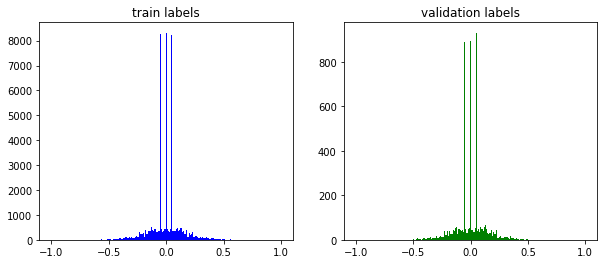

shape of train sample set: (43394, 2)
shape of validation sample set: (4822, 2)
Train labeling - mean: -0.00012054625259252446, std: 0.13562400218595907, min: -1.0, max: 1.0
Validation labeling - mean: 0.001084816276441311, std: 0.1310656406918641, min: -0.8926953999999999, max: 0.8926953999999999


In [41]:
correction = 0.05

samples = []

with open('./data/driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[3] == 'steering': 
                print(row)
            else:
                img_center = row[0].split("\\")[-1]
                img_center = img_center.split("/")[-1]
                img_left = row[1].split("\\")[-1]
                img_left = img_left.split("/")[-1]
                img_right = row[2].split("\\")[-1]
                img_right = img_right.split("/")[-1]
            
                img_center_flipped = 'flipped_' + img_center
                img_left_flipped = 'flipped_' + img_left
                img_right_flipped = 'flipped_' + img_right
            
                steering_center = float(row[3])
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                if steering_left > 1.:
                    steering_left = 1.
                if steering_right < -1.:
                    steering_right = -1.
            
                steering_center_flipped = -steering_center
                steering_left_flipped = -steering_left
                steering_right_flipped = -steering_right
            
                samples.append([img_center, steering_center])
                samples.append([img_left, steering_left])
                samples.append([img_right, steering_right])
                samples.append([img_center_flipped, steering_center_flipped])
                samples.append([img_left_flipped, steering_left_flipped])
                samples.append([img_right_flipped, steering_right_flipped])

samples = np.array(samples)

samples_view(samples)
train_samples, validation_samples = split_samples(samples)

Epoch 1/7
100s - loss: 0.0100 - val_loss: 0.0090
Epoch 2/7
99s - loss: 0.0091 - val_loss: 0.0082
Epoch 3/7
99s - loss: 0.0088 - val_loss: 0.0085
Epoch 4/7
99s - loss: 0.0086 - val_loss: 0.0086
Epoch 5/7
100s - loss: 0.0084 - val_loss: 0.0079
Epoch 6/7
100s - loss: 0.0082 - val_loss: 0.0081
Epoch 7/7
100s - loss: 0.0080 - val_loss: 0.0083


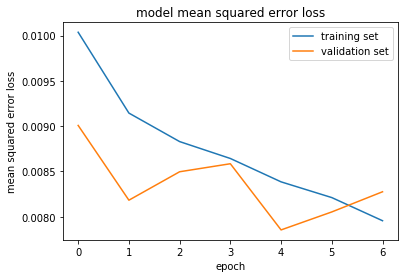

In [27]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
                              validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                              nb_epoch=7, verbose = 2)

training_plot(history)

Validation Loss: 0.008122141702349399


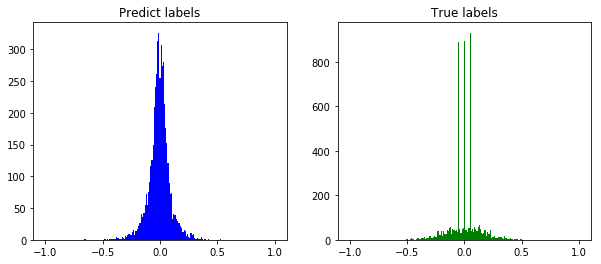

Prediction - mean: -0.006703507620841265, std: 0.09420736134052277, min: -0.6635544896125793, max: 0.525531530380249
Initial labeling - mean: 0.0010848162764413105, std: 0.13106564069186413, min: -0.8926953999999999, max: 0.8926953999999999


In [28]:
evaluate(validation_samples)

In [29]:
imodel = 20
model.save('model{}.h5'.format(imodel))
print('model saved')

model saved


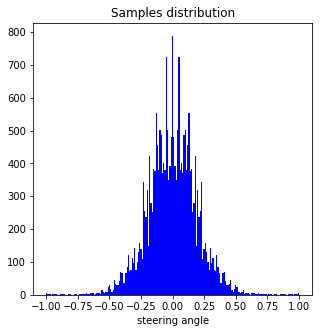

shape of sample set: (22950, 2)
Samples labeling - mean: 0.0, std: 0.19119087743251223, min: -1.0, max: 1.0


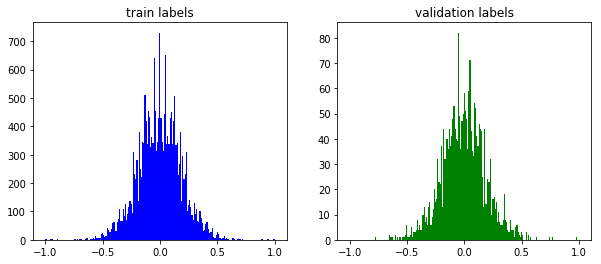

shape of train sample set: (20655, 2)
shape of validation sample set: (2295, 2)
Train labeling - mean: 0.00036398615269910456, std: 0.19144725540402718, min: -1.0, max: 1.0
Validation labeling - mean: -0.0032758753742919387, std: 0.18883624648298775, min: -0.771834, max: 0.9832381


In [30]:
shuffle(samples)
i1, i2, i3 = 0, 0, 0
new_samples = []
for sample in samples:
    if float(sample[1]) == 0.:
        if i1 < 300:
            i1 += 1
            new_samples.append(sample)
            
    elif float(sample[1]) == correction:
        if i2 < 300:
            i2 += 1
            new_samples.append(sample)
        
    elif float(sample[1]) == -correction:
        if i3 < 300:
            i3 += 1
            new_samples.append(sample)
            
    else:
        new_samples.append(sample)
            
samples = np.array(new_samples)
        
samples_view(samples)
train_samples, validation_samples = split_samples(samples)

Epoch 1/7
48s - loss: 0.0116 - val_loss: 0.0107
Epoch 2/7
47s - loss: 0.0109 - val_loss: 0.0102
Epoch 3/7
47s - loss: 0.0104 - val_loss: 0.0104
Epoch 4/7
47s - loss: 0.0097 - val_loss: 0.0096
Epoch 5/7
47s - loss: 0.0093 - val_loss: 0.0107
Epoch 6/7
47s - loss: 0.0088 - val_loss: 0.0098
Epoch 7/7
47s - loss: 0.0083 - val_loss: 0.0109


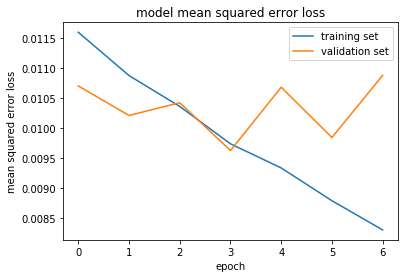

In [31]:
model = load_model('model{}.h5'.format(imodel))
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
                              validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                              nb_epoch=7, verbose = 2)

training_plot(history)

Validation Loss: 0.01016272625973152


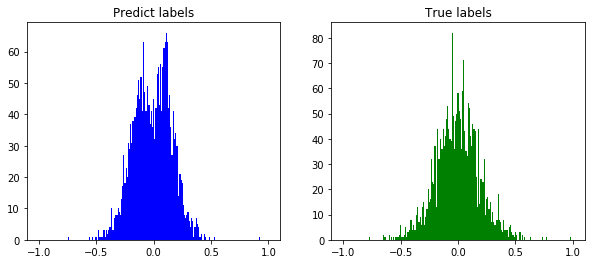

Prediction - mean: -0.008616018109023571, std: 0.16619791090488434, min: -0.7418753504753113, max: 0.9187386631965637
Initial labeling - mean: -0.003275875374291939, std: 0.18883624648298775, min: -0.771834, max: 0.9832381


In [32]:
evaluate(validation_samples)

In [33]:
imodel += 1
model.save('model{}.h5'.format(imodel))
print('model saved')

model saved


['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']


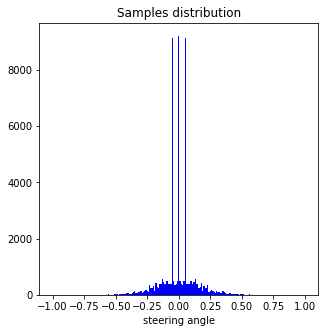

shape of sample set: (48216, 2)
Samples labeling - mean: 8.577195882546682e-20, std: 0.13517552986541395, min: -1.0, max: 1.0


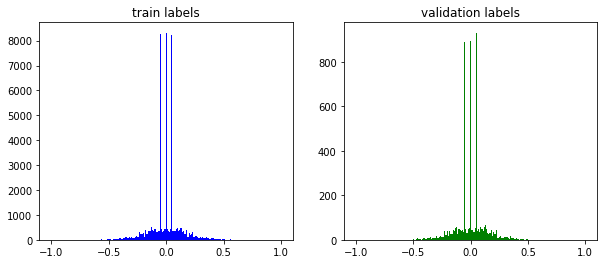

shape of train sample set: (43394, 2)
shape of validation sample set: (4822, 2)
Train labeling - mean: -0.00012054625259252446, std: 0.13562400218595907, min: -1.0, max: 1.0
Validation labeling - mean: 0.001084816276441311, std: 0.1310656406918641, min: -0.8926953999999999, max: 0.8926953999999999


In [34]:
correction = 0.05

samples = []

with open('./data/driving_log.csv', 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            if row[3] == 'steering': 
                print(row)
            else:
                img_center = row[0].split("\\")[-1]
                img_center = img_center.split("/")[-1]
                img_left = row[1].split("\\")[-1]
                img_left = img_left.split("/")[-1]
                img_right = row[2].split("\\")[-1]
                img_right = img_right.split("/")[-1]
            
                img_center_flipped = 'flipped_' + img_center
                img_left_flipped = 'flipped_' + img_left
                img_right_flipped = 'flipped_' + img_right
            
                steering_center = float(row[3])
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                if steering_left > 1.:
                    steering_left = 1.
                if steering_right < -1.:
                    steering_right = -1.
            
                steering_center_flipped = -steering_center
                steering_left_flipped = -steering_left
                steering_right_flipped = -steering_right
            
                samples.append([img_center, steering_center])
                samples.append([img_left, steering_left])
                samples.append([img_right, steering_right])
                samples.append([img_center_flipped, steering_center_flipped])
                samples.append([img_left_flipped, steering_left_flipped])
                samples.append([img_right_flipped, steering_right_flipped])

samples = np.array(samples)

samples_view(samples)
train_samples, validation_samples = split_samples(samples)

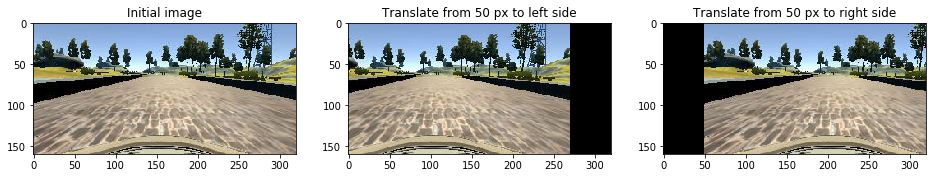

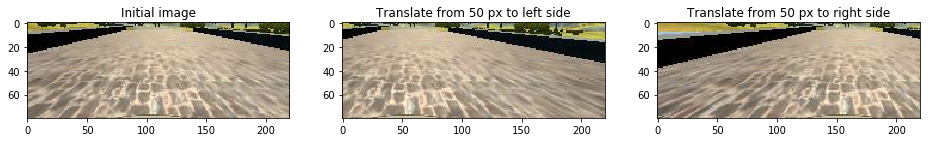

In [35]:
def translation(image, tx):
    M = np.float32([[1,0,tx],[0,1,0]])
    dst = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return dst

imagetr_l = translation(imread("./data/IMG/"+ ex_name), -50)
imagetr_r = translation(imread("./data/IMG/"+ ex_name), 50)
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Initial image')
plt.imshow(imread("./data/IMG/"+ ex_name))
plt.subplot(132)
plt.title('Translate from 50 px to left side')
plt.imshow(imagetr_l)
plt.subplot(133)
plt.title('Translate from 50 px to right side')
plt.imshow(imagetr_r)


imagetr_l = imagetr_l[60:-20, 50:-50]
imagetr_r = imagetr_r[60:-20, 50:-50]
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Initial image')
plt.imshow(imread("./data/IMG/"+ ex_name)[60:-20, 50:-50])
plt.subplot(132)
plt.title('Translate from 50 px to left side')
plt.imshow(imagetr_l)
plt.subplot(133)
plt.title('Translate from 50 px to right side')
plt.imshow(imagetr_r)



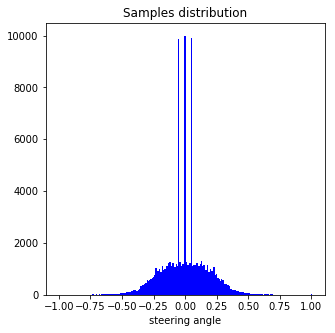

shape of sample set: (96432, 2)
Samples labeling - mean: 0.0005639858967977435, std: 0.1824830110829319, min: -1.0, max: 1.0


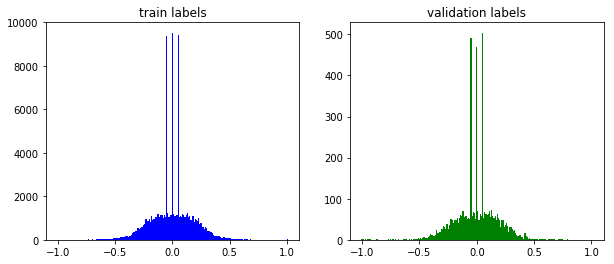

shape of train sample set: (91610, 2)
shape of validation sample set: (4822, 2)
Train labeling - mean: 0.0005842485048029692, std: 0.1823941559083872, min: -1.0, max: 1.0
Validation labeling - mean: 0.00017902996163417695, std: 0.1841625445540326, min: -1.0, max: 0.7926953999999999


In [36]:
new_samples = []
for sample in samples:
    random = randint(-150,150)
    translated_img = '{}_translated_{}'.format(random, sample[0])
    translated_steering = float(sample[1]) + random * 0.002
    if translated_steering > 1.:
        translated_steering = 1.
    if translated_steering < -1.:
        translated_steering = -1.
    new_samples.append(sample)
    new_samples.append([translated_img, translated_steering])
    
samples = np.array(new_samples)

samples_view(samples)
train_samples, validation_samples = split_samples(samples, test_size=0.05)

In [ ]:
shuffle(samples)
i1, i2, i3 = 0, 0, 0
new_samples = []
for sample in samples:
    if float(sample[1]) == 0.:
        if i1 < 1000:
            i1 += 1
            new_samples.append(sample)
            
    elif float(sample[1]) == correction:
        if i2 < 1000:
            i2 += 1
            new_samples.append(sample)
        
    elif float(sample[1]) == -correction:
        if i3 < 1000:
            i3 += 1
            new_samples.append(sample)
            
    else:
        new_samples.append(sample)
            
samples = np.array(new_samples)
        
samples_view(samples)
train_samples, validation_samples = split_samples(samples, test_size=0.05)

Epoch 1/5
203s - loss: 0.0097 - val_loss: 0.0089
Epoch 2/5
201s - loss: 0.0083 - val_loss: 0.0088
Epoch 3/5
202s - loss: 0.0079 - val_loss: 0.0083
Epoch 4/5
202s - loss: 0.0076 - val_loss: 0.0087
Epoch 5/5
201s - loss: 0.0073 - val_loss: 0.0084


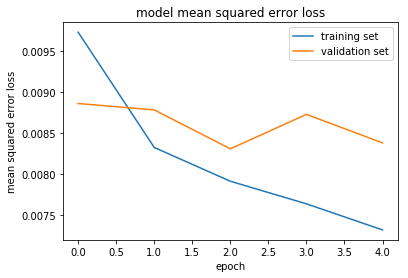

In [37]:
model = load_model('model{}.h5'.format(imodel))
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
                              validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                              nb_epoch=5, verbose = 2)

training_plot(history)

Validation Loss: 0.008352563586680907


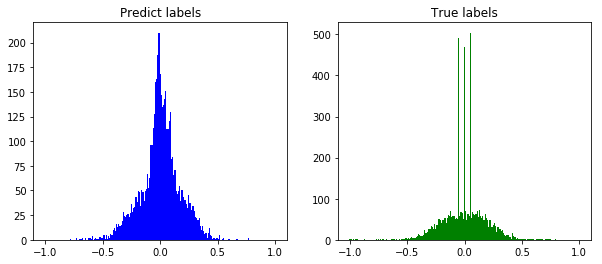

Prediction - mean: 0.00356965116225183, std: 0.17201781272888184, min: -0.7781834006309509, max: 0.7738295793533325
Initial labeling - mean: 0.00017902996163417643, std: 0.1841625445540326, min: -1.0, max: 0.7926953999999999


In [38]:
evaluate(validation_samples)

In [39]:
imodel += 1
model.save('model{}.h5'.format(imodel))
print('model saved')

model saved


In [ ]:
ex_image = cv2.GaussianBlur(ex_image, (3,3), 0)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))
print('dtype of image: {}'.format(ex_image.dtype))
print(ex_image.min(), ex_image.max())

In [ ]:
ex_image = cv2.cvtColor(ex_image, cv2.COLOR_RGB2YUV)
plt.figure(figsize=(8,8))
plt.imshow(ex_image)
print('Shape of image: {}'.format(ex_image.shape))
print('dtype of image: {}'.format(ex_image.dtype))
print(ex_image.min(), ex_image.max(),)

In [ ]:
plt.figure(figsize=(5, 5))
plt.hist(samples[:,1].astype(float), bins, facecolor = 'b', label = 'Training Label')
plt.show()
print('Samples labeling - mean: {}, std: {}, min: {}, max: {}'.format(samples[:,1].astype(float).mean(),
                                                                      samples[:,1].astype(float).std(),
                                                                      samples[:,1].astype(float).min(),
                                                                      samples[:,1].astype(float).max()))

In [ ]:
print(np.unique(samples[:,1].astype(float), return_counts=True))

In [ ]:
shuffle(samples)
i = 0
new_samples = []
for sample in samples:
    if -0.01 < float(sample[1]) < 0.01 :
        if i < 800:
            new_samples.append(sample)
            i += 1
    else:
        new_samples.append(sample)
            
samples = np.array(new_samples)       

samples_view(samples)